<a href="https://colab.research.google.com/github/philippedebeaumont/spark_etl_on_gcp/blob/main/ml/prophet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'london-bikes-ml' # Project ID inserted based on the query results selected to explore
location = 'europe-west9' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=london-bikes-ml:europe-west9:bquxjob_c4b2d25_18926a59eed)
back to BigQuery to edit the query within the BigQuery user interface.

In [48]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_c4b2d25_18926a59eed') # Job ID inserted based on the query results selected to explore
print(job.query)

WITH query AS (SELECT DISTINCT start_date, hire_count, prcp, tavg FROM `london-bikes-ml.london_cycles_dataset.daily_agg`)
SELECT start_date, SUM(hire_count) AS hire_count, MAX(prcp)  AS prcp, MAX(tavg) AS tavg FROM query GROUP BY start_date ORDER BY start_date


# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [49]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_c4b2d25_18926a59eed') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,start_date,hire_count,prcp,tavg
0,2019-09-11,9802,0.0,17.500000
1,2019-09-12,11316,0.0,18.400000
2,2019-09-13,10538,0.0,17.600000
3,2019-09-14,10305,0.0,16.600000
4,2019-09-15,9534,0.0,18.400000
...,...,...,...,...
1090,2022-09-07,8285,19.1,17.200001
1091,2022-09-08,5663,7.9,15.700000
1092,2022-09-09,6609,7.9,16.700001
1093,2022-09-10,1,6.9,16.900000


## Show descriptive statistics using describe()
Use the ```pandas DataFrame.describe()```
[method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
to generate descriptive statistics. Descriptive statistics include those that
summarize the central tendency, dispersion and shape of a dataset’s
distribution, excluding ```NaN``` values. You may also use other Python methods
to interact with your data.

In [50]:
results.describe()

,hire_count,prcp,tavg
count,1095.0,1086.000000,1095.000000
mean,7375.855708,1.783241,12.052877
std,4255.174654,3.786432,5.562269
min,1.0,0.000000,-1.300000
25%,4214.0,0.000000,7.600000
50%,6766.0,0.000000,11.600000
75%,10072.5,1.800000,16.600000
max,29361.0,33.299999,29.799999


In [51]:
results = results.fillna(0.0)

In [52]:
import holidays

In [53]:
years = [2019, 2020, 2021, 2022]

In [54]:
london_holidays = holidays.UnitedKingdom(years=years, prov='ENG', state='London')

In [76]:
import pandas as pd
holiday_dates = pd.DataFrame.from_dict(london_holidays, orient='index', columns=['ds'])
holiday_dates['holiday'] = 1
holiday_dates = holiday_dates.drop("ds", axis=1)

In [57]:
def get_holiday_value(results, holiday_dates):
  res = results.merge(holiday_dates, left_on="start_date", right_index=True, how="left")
  return res

In [82]:
res = get_holiday_value(results, holiday_dates)
res["start_date"] = res["start_date"].apply(str)

res = res.fillna(0)

In [92]:
from datetime import date
df = pd.DataFrame()
df = res[res["start_date"] < "2022-01-01"]
df = df.rename(columns={"start_date": "ds", "hire_count": "y"})
df = df.fillna(0.0)

In [93]:
from prophet import Prophet

In [94]:
model = Prophet()
model.add_regressor('prcp')
model.add_regressor('tavg')
model.add_regressor('holiday')
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp7xo9sw/e7achi7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwp7xo9sw/q34u32ov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12991', 'data', 'file=/tmp/tmpwp7xo9sw/e7achi7u.json', 'init=/tmp/tmpwp7xo9sw/q34u32ov.json', 'output', 'file=/tmp/tmpwp7xo9sw/prophet_modelwu3qeaaw/prophet_model-20230706121815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [102]:
N_PERIODS = 250
future = model.make_future_dataframe(periods=N_PERIODS)
test_data = pd.DataFrame()
test_data["prcp"] = pd.concat([res["prcp"][res["start_date"] < "2022-01-01"], res["prcp"][res["start_date"] >= "2022-01-01"][:N_PERIODS]])
test_data["tavg"] = pd.concat([res["tavg"][res["start_date"] < "2022-01-01"], res["tavg"][res["start_date"] >= "2022-01-01"][:N_PERIODS]])
test_data["holiday"] = pd.concat([res["holiday"][res["start_date"] < "2022-01-01"], res["holiday"][res["start_date"] >= "2022-01-01"][:N_PERIODS]])
test_data = test_data.fillna(0.0)

In [103]:
len(future)

1091

In [104]:
future

,ds
0,2019-09-11
1,2019-09-12
2,2019-09-13
3,2019-09-14
4,2019-09-15
...,...
1086,2022-09-03
1087,2022-09-04
1088,2022-09-05
1089,2022-09-06


In [105]:
test_data.isna().sum()

prcp       0
tavg       0
holiday    0
dtype: int64

In [106]:
future['prcp'] = test_data["prcp"]
future['tavg'] = test_data["tavg"]
future['holiday'] = test_data["holiday"]
future.tail()

,ds,prcp,tavg,holiday
1086,2022-09-03,0.0,18.700001,0.0
1087,2022-09-04,8.9,19.799999,0.0
1088,2022-09-05,2.5,19.200001,0.0
1089,2022-09-06,8.9,17.600000,0.0
1090,2022-09-07,19.1,17.200001,0.0


In [107]:
future.isna().sum()

ds         0
prcp       0
tavg       0
holiday    0
dtype: int64

In [124]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1086,2022-09-03,13580.134095,9545.622256,17051.403444
1087,2022-09-04,11697.706434,7753.040593,15599.305299
1088,2022-09-05,10611.516991,7082.752336,14717.195568
1089,2022-09-06,9745.803376,5744.841261,13511.681013
1090,2022-09-07,8149.375157,4261.795908,12172.562556


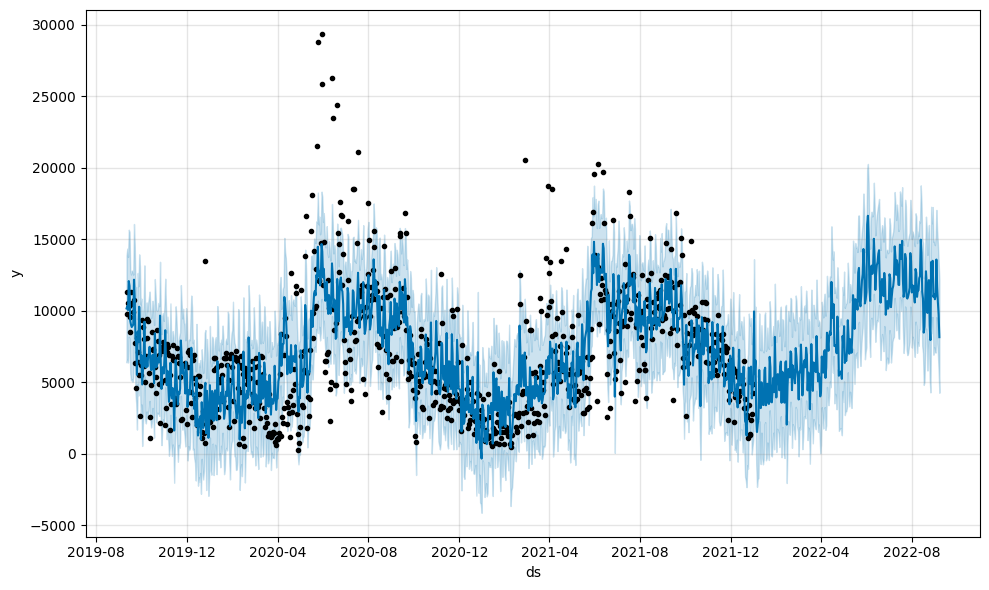

In [125]:
fig1 = model.plot(forecast)

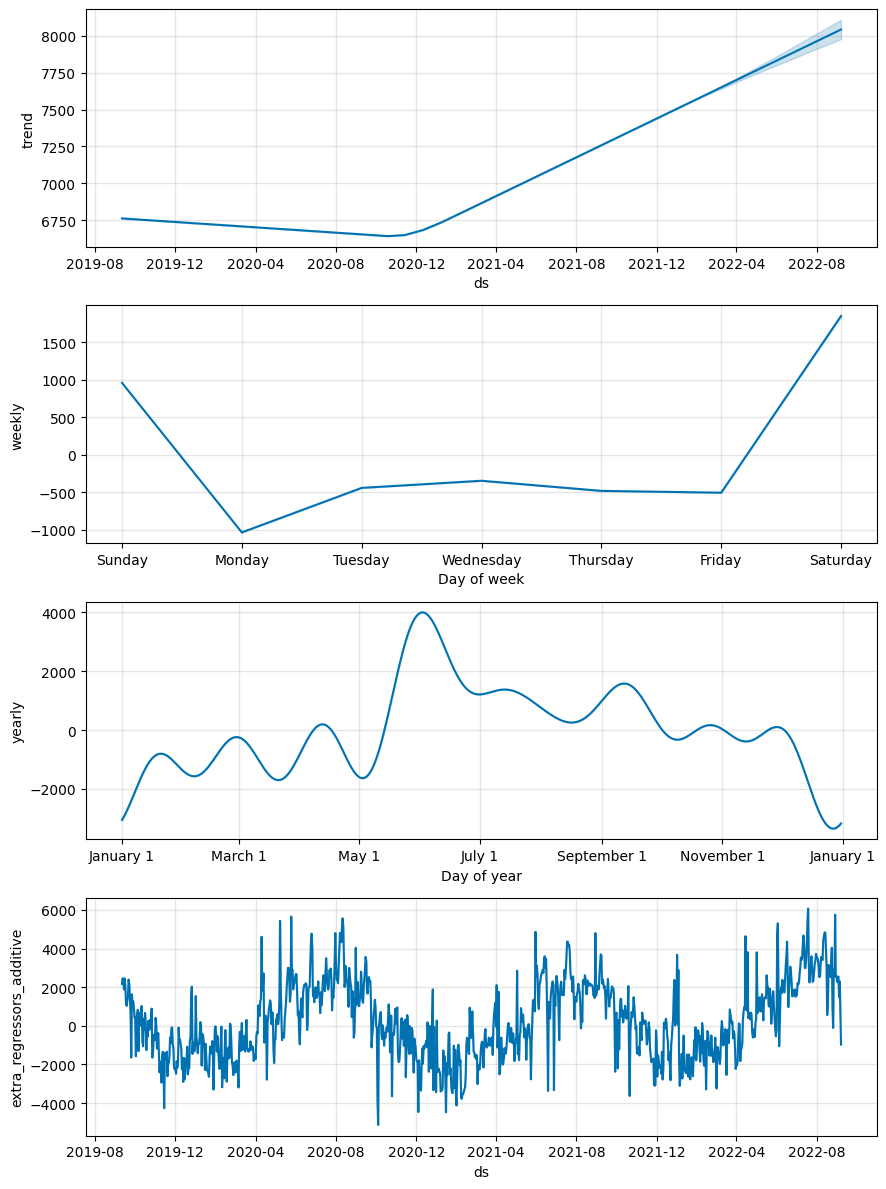

In [126]:
fig2 = model.plot_components(forecast)

In [127]:
testo_data = pd.DataFrame()
testo_data = pd.DataFrame()
testo_data["ds"] = res["start_date"][res["start_date"] >= "2022-01-01"][:N_PERIODS]
testo_data["y"] = res["hire_count"][res["start_date"] >= "2022-01-01"][:N_PERIODS]

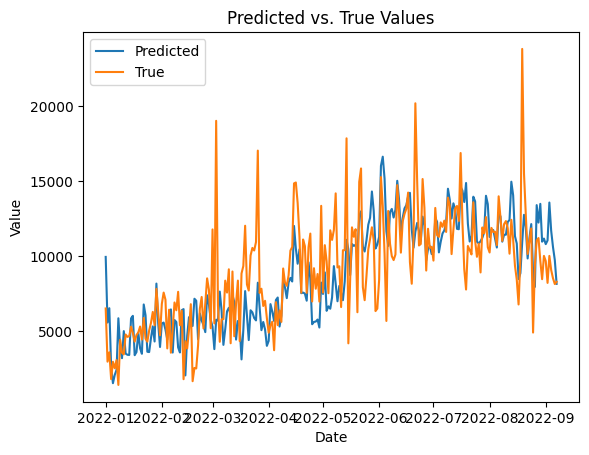

In [128]:
import matplotlib.pyplot as plt
true_values = pd.concat([results['hire_count'][res["start_date"] < "2022-01-01"], res['hire_count'][res["start_date"] >= "2022-01-01"][:N_PERIODS]])

# Combine the predicted and true values into a new DataFrame
combined_data = forecast[['ds', 'yhat']].join(true_values)

combined_data = combined_data[-N_PERIODS:]

# Plot the combined values
plt.plot(combined_data['ds'], combined_data['yhat'], label='Predicted')
plt.plot(combined_data['ds'], combined_data['hire_count'], label='True')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs. True Values')
plt.show()

In [129]:
import numpy as np

def smape(actual, predicted):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between actual and predicted values.

    Args:
        actual (array-like): Array of actual values.
        predicted (array-like): Array of predicted values.

    Returns:
        float: The SMAPE value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)

    numerator = np.abs(actual - predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2

    smape_score = np.mean(numerator / denominator) * 100

    return smape_score

In [130]:
smape(forecast["yhat"][len(forecast) - N_PERIODS:], testo_data["y"])

25.036706492986593